# Forest Fire Analysis: Saving Multiple Results in One Job

Wildfires have a significant impact on ecosystems, making it crucial to detect and analyze affected areas efficiently. In this notebook, we demonstrate how to use Sentinel-2 collections offered in the Copernicus Data Space Ecosystem (CDSE) to map wildfire, following the approach outlined in [Nolde et al. (2020)]( https://www.mdpi.com/2072-4292/12/13/2162#).

Here, we want to replicate only a part of the workflow. It involves calculating cloud-free NBR for pre, near-real-time(nrt) and post-fire data and comparing them.

Beyond showcasing this use case, we highlight the power of openEO's [`MultiResult`](https://open-eo.github.io/openeo-python-client/api.html#module-openeo.rest.multiresult) functionality, which allows multiple results to be retrieved within a single process call. This improves efficiency by enabling seamless access to both intermediate and final outputs in a structured manner.

In [1]:
import scipy
import numpy as np

import openeo
from openeo import MultiResult
from openeo.extra.spectral_indices import compute_indices

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as mpatches
import rasterio
from rasterio.plot import show

In [2]:
connection = openeo.connect("openeo.dataspace.copernicus.eu").authenticate_oidc()

Authenticated using refresh token.


To begin, we established a connection to CDSE backend in the previous step. 
The next step is to identify and define the area of interest (AOI) where we want to detect the wildfire and the temporal range for which we want to analyze the data.

For this usecase we select an area in Jaen/Spain where fire was noted on 2017/08/03 *(source: https://emergency.copernicus.eu/mapping/list-of-components/EMSR219)*.

In [3]:
extent = {"west": -2.6910, "south": 38.2239, "east": -2.5921, "north": 38.3002}

Since the objective is to analyze the differences between pre-, nrt- and post-fire, we will define separate time ranges for each as shown below:

In [4]:
pre_temporal_extent = ["2017-05-03", "2017-08-03"]
nrt_temporal_extent = ["2017-08-03", "2017-08-08"]
post_temporal_extent = ["2017-08-03", "2017-11-03"]

Wildfire regions often have cloud cover, making it difficult to assess the affected areas accurately. To address this, we preprocess the NBR data using the Best Available Pixel (BAP) method, which selects cloud-free pixels right before or after the fire event. It includes:
* We first create a cloud mask with an `SCL` band where we filter out pixels which have a cloud effect;
* Subsequently, a `Gaussian kernel` is created since the cloud masks are frequently noisy and may not completely encompass the cloud region;
* Next, we apply a smoothing function to the selected mask coupled with a morphometric dilation to increase and smooth the mask area. Here, for dilation, we select 11 pixels;
* Following this, a binary mask is produced by applying a threshold of 0.1. This implies that to be classified as cloud-free pixels, the pixels that have undergone smoothing and dilation should exhibit a value below 0.1.
* Once the required `mask` is generated, it is applied to the data cube;
* Finally, once the masked datacube is available, we want to select each cloud-free pixel as near the forest fire date as possible. To achieve this, we reduce the time dimension (`reduce_dimension`) based on the "last" criterion, which selects the nearest cloud-free pixel to the event date.

In [6]:
# define a function to identify cloud-free pixels in the available data-cube


def get_cloud_free_pixels(scl, data, reducer="first"):
    mask = (scl == 3) | (scl == 8) | (scl == 9) | (scl == 10)

    # mask is a bit noisy, so we apply smoothening
    # 2D gaussian kernel
    g = scipy.signal.windows.gaussian(11, std=1.6)
    kernel = np.outer(g, g)
    kernel = kernel / kernel.sum()

    # Morphological dilation of mask: convolution + threshold
    mask = mask.apply_kernel(kernel)
    mask = mask > 0.1

    data_masked = data.mask(mask)

    # now select Best Available Pixel based on the mask
    return data_masked.reduce_dimension(reducer=reducer, dimension="t")

## Calculate NBR

Though, NDVI is a good indicator of vegetation health, the Normalized Burn Ratio (NBR) index could be a better choice, which is more sensitive to burnt areas as suggested by Nolde et al.(2020).

*Quoted: "Optionally, the system can utilize the Normalized Burn Ratio (NBR) index ([40], see Equations (3) and (4)) instead of the NDVI. This index features superior capabilities for burnt area discrimination compared to the NDVI"*

Therefore, we define a reusable function to streamline the process of computing NBR for different time periods. This function loads the Sentinel-2 L2A collection, calculates NBR, and applies the `get_cloud_free_pixels` method. By adjusting the time range and reducer, we can use the same function for pre-fire, near-real-time, and post-fire NBR calculations.

To analyze the vegetation state before the wildfire, we load the Sentinel-2 L2A collection with few bands and calculate the NBR. Using the similar method we calculate the NBR for the near-real-time and post-fire period with different time ranges and reducers passed to the  method.

In [7]:
def cal_nbr(temporal_extent, reducer):
    s2_cube = connection.load_collection(
        "SENTINEL2_L2A",
        temporal_extent=temporal_extent,
        spatial_extent=extent,
        bands=["B08", "B12"],
        max_cloud_cover=90,
    )

    scl = connection.load_collection(
        "SENTINEL2_L2A",
        temporal_extent=temporal_extent,
        spatial_extent=extent,
        bands=["SCL"],
        max_cloud_cover=90,
    )

    # compute NBR
    nbr = compute_indices(s2_cube, indices=["NBR"])
    
    # get Best Available Pixel
    nbr_cloud_free = get_cloud_free_pixels(scl, nbr, reducer=reducer)

    return nbr_cloud_free


To analyze wildfire impact, we compute NBR for three key phases, each requiring a different temporal range and reducer to handle cloud cover effectively:
1. Pre-event NBR – We use the "last" reducer to select the most recent cloud-free pixel before the fire, ensuring an accurate baseline for comparison.
2. Near-Real-Time (NRT) NBR – Since immediate detection is crucial, we use the "first" reducer to select the earliest available image after the fire, even if some cloud cover remains.
3. Post-event NBR – Similar to pre-event processing, we use the "first" reducer to capture the earliest cloud-free pixel after the fire, ensuring reliable post-fire assessment.


In [8]:
nbr_pre = cal_nbr(pre_temporal_extent, "last")
nbr_nrt = cal_nbr(nrt_temporal_extent, "first")
nbr_post = cal_nbr(post_temporal_extent, "first")

At this stage, we have only defined the workflow but have not executed it yet. Instead of running the process immediately and recalculating NBR each time, we save intermediate results in GeoTIFF format. This allows us to efficiently store and retrieve data without reprocessing, saving both time and resources.

In [9]:
# first result
nbr_pre_result = nbr_pre.save_result(format="GTiff", options={"filename_prefix": "NBR"})

# save NBR for NRT mode for comparison as second intermediate result
nbr_nrt_result = nbr_nrt.save_result(format="GTiff", options={"filename_prefix": "NRT_NBR"})

# save NBR for post-event mode for comparison
nbr_post_result = nbr_post.save_result(format="GTiff", options={"filename_prefix": "Post_NBR"})

In [10]:
# a quick view on the process graph
nbr_post_result

Now that we have defined and saved multiple NBR results, we can execute the workflow. Instead of running separate jobs for each result, we use openEO’s [`MultiResult`](https://open-eo.github.io/openeo-python-client/api.html#module-openeo.rest.multiresult) feature, which allows us to save multiple results from different steps in a single job. 

Using [`MultiResult`](https://open-eo.github.io/openeo-python-client/api.html#module-openeo.rest.multiresult) is beneficial because it enables efficient execution by reducing redundant result-saving steps. Instead of running individual computations for each NBR dataset, we bundle them together and execute them in one go. This approach optimizes resource usage and minimizes processing overhead.

Handling multiple outputs in a single job ensures consistency in the results and makes tracking and organising different NBR datasets easier. This is particularly useful when dealing with complex workflows that involve multiple processing steps.

To implement this, we combine all our intermediate NBR results into a MultiResult object and create a job to execute.

In [ ]:
multi_result_nbr = MultiResult([nbr_pre_result,nbr_nrt_result,nbr_post_result])
nbr_job = multi_result_nbr.create_job(title="Multiple save result NBR")
nbr_job.start_and_wait()

0:00:00 Job 'j-250308125840445487855554db24e893': send 'start'
0:00:13 Job 'j-250308125840445487855554db24e893': created (progress 0%)
0:00:18 Job 'j-250308125840445487855554db24e893': created (progress 0%)
0:00:25 Job 'j-250308125840445487855554db24e893': created (progress 0%)
0:00:33 Job 'j-250308125840445487855554db24e893': running (progress N/A)
0:00:43 Job 'j-250308125840445487855554db24e893': running (progress N/A)
0:00:56 Job 'j-250308125840445487855554db24e893': running (progress N/A)
0:01:11 Job 'j-250308125840445487855554db24e893': running (progress N/A)
0:01:30 Job 'j-250308125840445487855554db24e893': running (progress N/A)
0:01:54 Job 'j-250308125840445487855554db24e893': running (progress N/A)
0:02:24 Job 'j-250308125840445487855554db24e893': running (progress N/A)
0:03:02 Job 'j-250308125840445487855554db24e893': running (progress N/A)
0:03:48 Job 'j-250308125840445487855554db24e893': finished (progress 100%)


<BatchJob job_id='j-250308125840445487855554db24e893'>

In [ ]:
results = nbr_job.get_results()
results.download_files("data/out")

[WindowsPath('data/out/NBR.tif'),
 WindowsPath('data/out/NRT_NBR.tif'),
 WindowsPath('data/out/Post_NBR.tif'),
 WindowsPath('data/out/job-results.json')]

### Plot the NBR

Now we have the NBR and its difference which can be treated as a proxy of forest fire. Let's visualize them, first the NBR alone and then the mapped forest fire from it.

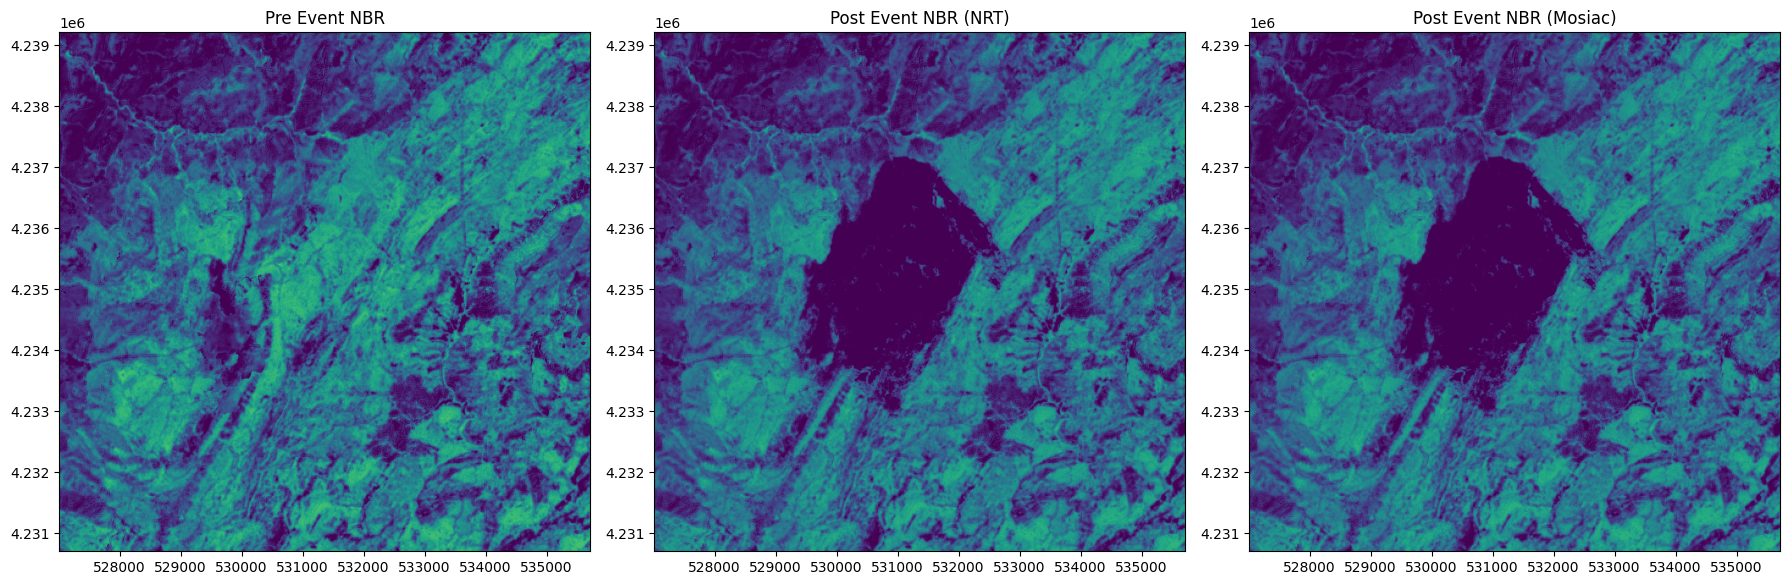

In [24]:
nbr = rasterio.open("data/out/NBR.tif")
nbr_nrt = rasterio.open("data/out/NRT_NBR.tif")
nbr_mosiac = rasterio.open("data/out/Post_NBR.tif")

f, axarr = plt.subplots(1, 3, dpi=100, figsize=(18, 6))
im = show(nbr.read(1), vmin=0, vmax=1, transform=nbr.transform, ax=axarr[0])
axarr[0].set_title("Pre Event NBR")

im = show(nbr_nrt.read(1), vmin=0, vmax=1, transform=nbr_nrt.transform, ax=axarr[1])
axarr[1].set_title("Post Event NBR (NRT)")

im = show(
    nbr_mosiac.read(1), vmin=0, vmax=1, transform=nbr_mosiac.transform, ax=axarr[2]
)
axarr[2].set_title("Post Event NBR (Mosiac)")
plt.tight_layout()

As we can see, the location of the forest fire is quite prominent in the post-event NBR images compared to that of the pre-event NBR images. This shows that the approach with NBR has better visibility of forest fire signals than the NDVI-based approach. Now, let's see how the final output of the forest fire area looks with the NBR difference image.

## Ground Truth

As a validation of this workflow, we have a map provided by Copernicus Emergency Management Service (CEMS) is shown below:

<img src="gt.png" alt="Ground Truth" width="1000"/>